In [2]:
import pandas as pd
#read data and  exchange to datetime type
df1 = pd.read_csv('Stanford 15-min emissions data.csv')
df2 = pd.read_csv('sort_meterDF_SOOFIE(1).csv')
def tran_num(x):
    '''
    change to number from string
    '''
    x = x.replace(',','')
    return float(x)
    
df1['emission'] = df1['emission'].apply(tran_num)
df1['sci_av_time'] = pd.to_datetime(df1['id'], format='Stanford:%Y-%m-%dT%H:%M')
df2['date'] = df2['date'].apply(lambda x:x[0:-6])
df2['meter_time'] = pd.to_datetime(df2['date'], format='%Y-%m-%d %H:%M:%S')#2021-10-17 17:43:59+00:00

In [3]:
#rolling 15 min
# df2['instantaneous_kgh_roll'] = df2['moving_kgh'].rolling(window=1500).mean()

In [7]:
#sort_meterDF_SOOFIE(1) only retain the 15min data
df2['check'] = False
for i in range(len(df2)):
    if df2['meter_time'].iloc[i].minute % 15 == 0 and df2['meter_time'].iloc[i].second % 60 == 0:
        df2['check'].iloc[i] = True
df2_15_min =  df2[df2['check'] == True]


/Users/xiaohanli/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
# split to time series and not time series
begin = [1119,1042,983,925,863,814,754,684,544,483,422,114,61]
end = [1129,1051,996,932,875,817,760,687,553,487,430,129,70]
df1['emi'] = True
for i in range(len(df1)):
    for begin1,end1 in zip(begin,end):
        if i >=begin1 and i < end1:
            df1.loc[i,'emi'] = False
df1_not_in_time = df1[df1['emi']==True]
df1_in_time = df1[df1['emi']==False]


In [5]:
#
import numpy as np
def cal_con_matrix(df2,df1):
    '''
    calculate the confusion matrix
    '''
    TN = 0
    FP = 0
    FN = 0
    TP = 0
    for i in range(len(df1)):
        for j in range(len(df2)):
            #find the same time
            delta = df1['sci_av_time'].iloc[i] - df2['meter_time'].iloc[j]
            if delta.seconds == 0 and delta.days == 0:
                
                if df1['emission'].iloc[i] != 0 and df2['moving_kgh'].iloc[j] != 0:
                    TP += 1
                if df1['emission'].iloc[i] != 0 and df2['moving_kgh'].iloc[j] == 0:
                    FP += 1
                if df1['emission'].iloc[i] == 0 and df2['moving_kgh'].iloc[j] != 0:
                    FN += 1
                if df1['emission'].iloc[i] == 0 and df2['moving_kgh'].iloc[j] == 0:
                    TN += 1
    return np.array([[TP,FP],[FN,TN]])
matrix1 = cal_con_matrix(df2_15_min,df1_not_in_time)
matrix2 = cal_con_matrix(df2_15_min,df1_in_time)
matrix3 = matrix1 + matrix2


In [5]:
#
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
def plot_confusion_matrix(cm,title):
    plt.figure(figsize=(12,8))
    colors = ['white','#8C1515']
    cmap1 = mcolors.LinearSegmentedColormap.from_list('cmap1', colors)
    plt.imshow(cm,cmap=cmap1)    # 在特定的窗口上显示图像
    plt.title(title,fontsize=20)    # 图像标题
    plt.colorbar()
    labels_name = ['Positive','Negative']
    labels_name2 = ['Positive','Negative']
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name2)    # 将标签印在y轴坐标上
    plt.ylabel('Stanford Release Volume')
    plt.xlabel('Sci Avi Release Volume')
    all_cm = cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
    plt.text(0,0,'TP\n{0}\n{1:.2f}%'.format(cm[0][0],cm[0][0]/all_cm*100),fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")
    plt.text(1,0,'FP\n{0}\n{1:.2f}%'.format(cm[0][1],cm[0][1]/all_cm*100),fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")
    plt.text(0,1,'FN\n{0}\n{1:.2f}%'.format(cm[1][0],cm[1][0]/all_cm*100),fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")
    plt.text(1,1,'TN\n{0}\n{1:.2f}%'.format(cm[1][1],cm[1][1]/all_cm*100),fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")
    plt.show()
    
plot_confusion_matrix(matrix2,'Confusion matrix During the Hour Release')
plot_confusion_matrix(matrix1,'Confusion matrix Off the Hour Released')
plot_confusion_matrix(matrix3,'Confusion matrix')


NameError: name 'matrix2' is not defined

66
97
max_me 1588.03


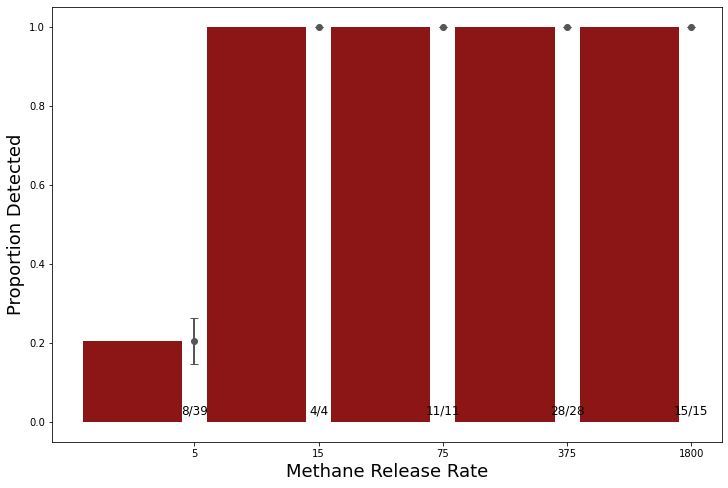

In [29]:
#放大图
#实现条形图
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def cal_data(df2,df1):
    '''
    calculate the confusion matrix
    '''
    TN = 0
    FP = 0
    FN = 0
    TP = 0
    #计算FP的15分钟数据
    lst1 = []
    #计算15分钟数据所有非零的数据
    lst2 = []
    for i in range(len(df1)):
        for j in range(len(df2)):
            #find the same time
            delta = df1['sci_av_time'].iloc[i] - df2['meter_time'].iloc[j]
            if delta.seconds == 0 and delta.days == 0:
                
                if df1['emission'].iloc[i] != 0 and df2['moving_kgh'].iloc[j] != 0:
                    TP += 1
                    lst1.append(df1['emission'].iloc[i])
                    lst2.append(df1['emission'].iloc[i])
                if df1['emission'].iloc[i] != 0 and df2['moving_kgh'].iloc[j] == 0:
                    FP += 1
                if df1['emission'].iloc[i] == 0 and df2['moving_kgh'].iloc[j] != 0:
                    lst2.append(df1['emission'].iloc[i])
                    FN += 1
                if df1['emission'].iloc[i] == 0 and df2['moving_kgh'].iloc[j] == 0:
                    TN += 1
          
    return lst1,lst2

def draw_bar(lst1,lst2):
    '''
    lst1:FP的15分钟数据
    lst2:15分钟数据所有非零的数据
    '''
    max_me = max(lst2)
    print('max_me',max_me)
    x = []
    q = max_me//(max_me//10)
    for i in range(int(q+2)):
        x.append(i*(max_me//10))
    x = [0,5,15,75,375,1800]
    plt.figure(figsize=(12,8))
    count1 = []
    count2 = []
    y = []
    var_lst = []
    num1 = 0
    for j in range(len(lst1)):
        if lst1[j] >= x[0] and lst1[j]<=x[1]:
            num1 += 1
    count1.append(num1)    
    num2 = 0
    var = []
    for j in range(len(lst2)):
        if lst2[j] >= x[0] and lst2[j]<=x[1]:
            var.append(lst2[j])
            num2 += 1
    var_lst.append(var)
    count2.append(num2)
    if num2 == 0:
        y.append(0)
    else:
        y.append(num1/num2)
    for i in range(1,len(x)-1):
        num1 = 0
        var = []
        for j in range(len(lst1)):
            
            if lst1[j] > x[i] and lst1[j] <= x[i+1]:
                num1 = num1 + 1
        count1.append(num1)
        num2 = 0
        for j in range(len(lst2)):
            
            if lst2[j] > x[i] and lst2[j] <= x[i+1]:
                var.append(lst2[j])
                num2 = num2 + 1
        var_lst.append(var)
        count2.append(num2)
        if num2 == 0:
            y.append(0)
        else:
            y.append(num1/num2)
    x_ticks = []
    for i in range(len(y)):
        x_ticks.append(i)
    plt.bar(np.array(x_ticks)-0.5,y,color = '#8C1515')
    plt.xticks(x_ticks,x[1:])
    plt.xlabel('Methane Release Rate',fontsize=18)
    plt.ylabel('Proportion Detected',fontsize=18)
    plt.ylim(-0.05,1.05)
    var_lst_new = [] # 归一化
    for var in var_lst:
        var = [i/max(var) for i in var]
        var_lst_new.append(var)
    error=[np.var(i) for i in var_lst_new] # 误差范围函数
    error_not_0 = []
    for i in range(len(y)):
        if y[i] != 1:
            error_not_0.append(error[i])
        else:
            error_not_0.append(0)
    error_range=[error_not_0,error_not_0] #下置信度和上置信度
#     plt.errorbar(x_ticks,y,yerr=error_range)
    plt.errorbar(x_ticks,y,yerr=error_range,fmt='o',ecolor='#53565A',color='#53565A',elinewidth=2,capsize=4)
    for i in range(len(y)):
        plt.text(x_ticks[i],0.02,str(count1[i])+'/'+str(count2[i]),fontsize=12,horizontalalignment='center')
    plt.show()
    
if __name__ == '__main__':
    
    lst1,lst2 = cal_data(df2_15_min,df1_in_time)
    print(len(lst1))
    print(len(lst2))
    draw_bar(lst1,lst2)
    